In [14]:
import os
import sys
import json
import torch
import math

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch.distributions import Categorical,Multinomial,Dirichlet

from typing import Union

def hellinger_mjps(
        mjp_1:torch.Tensor,
        mjp_0:torch.Tensor,
        type:str="time_average",
        to_uniform:bool=False,
        sample_size:int = 500
    )->Union[float,torch.Tensor]:
    """
    Calculates helliger distance for time series of histograms of MJPs,

    parameters
    ----------
    mjp_1: torch.Tensor(number_of_time_steps,number_of_states) NORMALIZED
    mjp_0:torch.Tensor(number_of_time_steps,number_of_states) NORMALIZED
    type: # time_average, sum, max, gap, timeseries if timeseries returns a timeseries
    sample_size: number of paths required to obtain the mjps histogram

    returns
    -------
    distance: float,torch.Tensor 
    """
    number_of_time_steps = mjp_1.shape[0]
    number_of_states = mjp_1.shape[1]
    distance = (torch.sqrt(mjp_1) - torch.sqrt(mjp_0))**2.
    distance = (1./math.sqrt(2.))*distance.sum(axis=1)

    if to_uniform:
        uniform = torch.full((number_of_time_steps,number_of_states,),1.)/number_of_states
        uniform_sample = Multinomial(sample_size,uniform).sample()

        distance_to_uniform = (torch.sqrt(mjp_1) - torch.sqrt(uniform_sample))**2.
        distance_to_uniform = (1./math.sqrt(2.))*distance_to_uniform.sum(axis=1)
        
        distance = distance/distance_to_uniform

    if type == "time_average":
        distance = distance.mean(axis=0)
    elif type == "sum":
        distance = distance.sum(axis=0)
    elif type == "max":
        distance = torch.max(distance)
    elif type == "gap":
        distance = (torch.max(distance) - torch.min(distance))*.5
    elif type == "timeseries":
        return distance
    
    distance = distance.item()
    return distance

In [4]:
os.listdir(".")

['distance_no_uniform.csv',
 'distance_uniform.csv',
 'gillespie.py',
 'HD_MJPS_no_uniform.png',
 'HD_MJPS_uniform.png',
 'histograms-time.txt',
 'histogram_animation.gif',
 'MJ.ipynb',
 'MJP_and_stationarity.ipynb',
 'MJP_distance_from_data.ipynb',
 'my_animation.gif',
 'new-histogram-set.txt',
 'ot_between_mjp.ipynb']

In [4]:
with open("histograms-time.txt") as f:
    data = json.load(f)
mjp_string_name  = ['V=0', 'V=0.1', 'V=0.2', 'V=0.3', 'V=0.4', 'V=0.5', 'V=0.6', 'V=0.7', 'V=0.8', 'V=0.9', 'V=1.0']
real_mjp = torch.Tensor(data["true_data"]).squeeze()
mjps = {name:torch.Tensor(data[name]).squeeze() for name in mjp_string_name}
mjp_0 = real_mjp

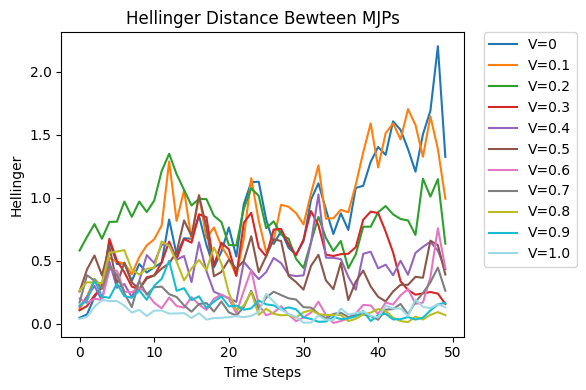

In [120]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Set figure size
plt.figure(figsize=(6, 4))

# Create a color map
num_series = len(mjps)  # Assuming 'mjps' contains all series
colors = cm.tab20(np.linspace(0, 1, num_series))

# Plot each time series with a unique color from the color map
for idx, (mjp_name, mjp_1) in enumerate(mjps.items()):
    distance = hellinger_mjps(mjp_1, mjp_0, to_uniform=True, type="timeseries",sample_size=300)
    plt.plot(distance.numpy(), label=mjp_name, color=colors[idx])

plt.title("Hellinger Distance Bewteen MJPs")
plt.ylabel("Hellinger")
plt.xlabel("Time Steps")
# Place legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Optimize layout to make room for the legend
plt.tight_layout()

# Show plot
plt.savefig("HD_MJPS_uniform.png")

In [90]:
rows = ["time_average", "sum", "max", "gap"]

In [104]:
data_frame_dict = {distance_type:[] for distance_type in rows}
for distance_type in rows:
    # Plot each time series with a unique color from the color map
    for idx, (mjp_name, mjp_1) in enumerate(mjps.items()):
        distance = hellinger_mjps(mjp_1, mjp_0, to_uniform=True, type=distance_type)
        data_frame_dict[distance_type].append(distance)
df_to_uniform = pd.DataFrame.from_dict(data_frame_dict, orient='index', columns=mjps.keys())


In [105]:
data_frame_dict = {distance_type:[] for distance_type in rows}
for distance_type in rows:
    # Plot each time series with a unique color from the color map
    for idx, (mjp_name, mjp_1) in enumerate(mjps.items()):
        distance = hellinger_mjps(mjp_1, mjp_0, to_uniform=False, type=distance_type)
        data_frame_dict[distance_type].append(distance)
df = pd.DataFrame.from_dict(data_frame_dict, orient='index', columns=mjps.keys())

In [109]:
df.to_csv("distance_no_uniform.csv")
df_to_uniform.to_csv("distance_uniform.csv")

In [122]:
df_to_uniform

,V=0,V=0.1,V=0.2,V=0.3,V=0.4,V=0.5,V=0.6,V=0.7,V=0.8,V=0.9,V=1.0
time_average,0.144332,0.155196,0.155732,0.094678,0.078799,0.090956,0.040994,0.039331,0.049351,0.039521,0.022497
sum,7.244875,7.745179,7.839389,4.738289,3.944100,4.592851,2.031295,1.967017,2.444684,1.985904,1.133940
max,0.346243,0.321333,0.270925,0.174933,0.151579,0.184049,0.162830,0.084984,0.129610,0.097569,0.050631
gap,0.169771,0.151050,0.090432,0.080293,0.065532,0.068985,0.079414,0.038969,0.065246,0.048477,0.024931


## Different Sizes Dataset

In [5]:
with open("new-histogram-set.txt") as f:
    data = json.load(f)
mjp_string_name  = ['V=0', 'V=0.1', 'V=0.2', 'V=0.3', 'V=0.4', 'V=0.5', 'V=0.6', 'V=0.7', 'V=0.8', 'V=0.9', 'V=1.0']
real_mjp = torch.Tensor(data["true_data"]).squeeze()
mjps = {name:torch.Tensor(data[name]).squeeze() for name in mjp_string_name}

In [6]:
def get_aggregate(mjp_aggregate,index_of_realizations=2):
    mjp_aggregate = mjp_aggregate[:index_of_realizations]
    mjp_aggregate = mjp_aggregate.sum(axis=0)
    return mjp_aggregate

In [67]:
data_frames = {}
mjp_0 = real_mjp/200.
for index_of_realizations in range(1,10):
    sample_size = 200*index_of_realizations
    rows = ["time_average", "sum", "max", "gap"]
    data_frame_dict = {distance_type:[] for distance_type in rows}
    for distance_type in rows:
        # Plot each time series with a unique color from the color map
        for idx, (mjp_name, mjp_1) in enumerate(mjps.items()):
            mjp_aggregate = get_aggregate(mjp_1,index_of_realizations=index_of_realizations)/sample_size
            distance = hellinger_mjps(mjp_aggregate, mjp_0, to_uniform=True, type=distance_type,sample_size=sample_size)
            data_frame_dict[distance_type].append(distance)
    df_to_uniform = pd.DataFrame.from_dict(data_frame_dict, orient='index', columns=mjps.keys())
    data_frames[sample_size] = df_to_uniform


In [68]:
data_frames[200]

,V=0,V=0.1,V=0.2,V=0.3,V=0.4,V=0.5,V=0.6,V=0.7,V=0.8,V=0.9,V=1.0
time_average,0.000341,0.000284,0.000208,0.000224,0.000207,0.000165,0.000121,0.000153,0.000057,0.000097,0.000070
sum,0.017052,0.014188,0.010421,0.011219,0.010336,0.008241,0.006060,0.007625,0.002872,0.004834,0.003488
max,0.000591,0.000565,0.000439,0.000390,0.000392,0.000373,0.000260,0.000352,0.000124,0.000235,0.000177
gap,0.000249,0.000243,0.000210,0.000153,0.000164,0.000184,0.000126,0.000154,0.000062,0.000112,0.000088


In [69]:
data_frames[400]

,V=0,V=0.1,V=0.2,V=0.3,V=0.4,V=0.5,V=0.6,V=0.7,V=0.8,V=0.9,V=1.0
time_average,0.000119,0.000117,0.000119,0.000115,0.000094,0.000073,0.000059,0.000051,0.000027,0.000036,0.000034
sum,0.005961,0.005846,0.005963,0.005755,0.004689,0.003667,0.002969,0.002573,0.001344,0.001792,0.001711
max,0.000239,0.000198,0.000185,0.000202,0.000168,0.000161,0.000143,0.000103,0.000051,0.000095,0.000094
gap,0.000106,0.000086,0.000084,0.000085,0.000068,0.000078,0.000065,0.000047,0.000023,0.000045,0.000045


In [74]:
mjp_s = {}
for mjp_str in mjps.keys():
    mjp_s[mjp_str] = []
    for sample_size in data_frames.keys():
        v = data_frames[sample_size][mjp_str]["time_average"]
        mjp_s[mjp_str].append(v)

In [75]:
data_frames[200]

,V=0,V=0.1,V=0.2,V=0.3,V=0.4,V=0.5,V=0.6,V=0.7,V=0.8,V=0.9,V=1.0
time_average,0.000341,0.000284,0.000208,0.000224,0.000207,0.000165,0.000121,0.000153,0.000057,0.000097,0.000070
sum,0.017052,0.014188,0.010421,0.011219,0.010336,0.008241,0.006060,0.007625,0.002872,0.004834,0.003488
max,0.000591,0.000565,0.000439,0.000390,0.000392,0.000373,0.000260,0.000352,0.000124,0.000235,0.000177
gap,0.000249,0.000243,0.000210,0.000153,0.000164,0.000184,0.000126,0.000154,0.000062,0.000112,0.000088


In [76]:
data_frames[800]

,V=0,V=0.1,V=0.2,V=0.3,V=0.4,V=0.5,V=0.6,V=0.7,V=0.8,V=0.9,V=1.0
time_average,0.000056,0.000050,0.000051,0.000041,0.000041,0.000035,0.000026,0.000023,0.000012,0.000013,0.000012
sum,0.002819,0.002492,0.002566,0.002068,0.002046,0.001732,0.001293,0.001129,0.000608,0.000665,0.000615
max,0.000105,0.000093,0.000086,0.000067,0.000075,0.000067,0.000053,0.000040,0.000029,0.000028,0.000033
gap,0.000046,0.000044,0.000041,0.000030,0.000030,0.000029,0.000023,0.000016,0.000014,0.000013,0.000016


In [77]:
mjp_s["V=0.5"]

[0.00016482092905789614,
 7.333520625252277e-05,
 4.909565541311167e-05,
 3.463634493527934e-05,
 2.4658627808094025e-05,
 1.9078874174738303e-05,
 1.6636859072605148e-05,
 1.4129028386378195e-05,
 1.2969710041943472e-05]

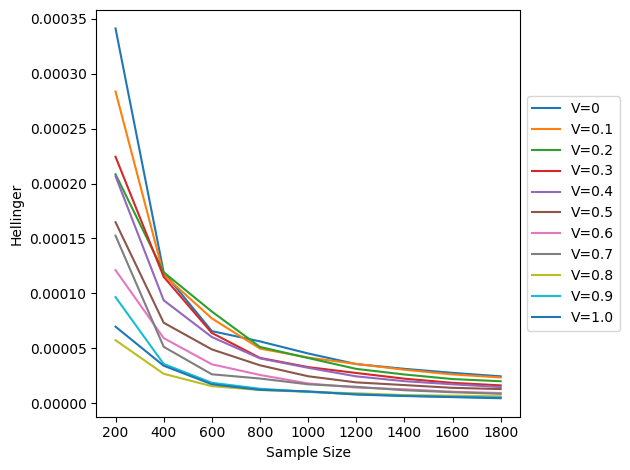

In [79]:

import matplotlib.pyplot as plt

# Plotting each method with a different color
for name_ in mjp_s.keys():
    plt.plot([(i+1)*200 for i in range(9)], mjp_s[name_], label=name_)

# Labeling the axes
plt.ylabel("Hellinger")
plt.xlabel("Sample Size")

# Moving the legend outside the plot to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to make space for the legend
plt.tight_layout()

# Saving the plot as a PNG file
plt.savefig("HellingerVSsamplesize_TIMEAV.png", bbox_inches='tight')

# Display the plot
plt.show()



## Sample Size Variance

In [3]:
with open("new-histogram-data.txt") as f:
    data = json.load(f)
mjp_string_name  = ['V=0', 'V=0.1', 'V=0.2', 'V=0.3', 'V=0.4', 'V=0.5', 'V=0.6', 'V=0.7', 'V=0.8', 'V=0.9', 'V=1.0']
real_mjp = torch.Tensor(data["true_data"]).squeeze()
mjps = {name:torch.Tensor(data[name]).squeeze() for name in mjp_string_name}

In [10]:
real_mjp.shape

torch.Size([10, 50, 6])

In [ ]:
mjps

In [20]:
sample_size = 200
mjps_distance_stats = {}

rows = ["time_average", "sum", "max", "gap"]

# Plot each time series with a unique color from the color map
for idx, (mjp_name, mjp_1) in enumerate(mjps.items()):
    data_frame_dict = {distance_type:[] for distance_type in rows}
    mjps_distance_stats[mjp_name] = data_frame_dict
    for distance_type in rows:
        for realization_index_i in range(9):
            mjp_0 = real_mjp[realization_index_i]/200.
            for realization_index_j in range(9):
                mjp_target = mjp_1[realization_index_j].squeeze()/sample_size
                distance = hellinger_mjps(mjp_target, mjp_0, to_uniform=True, type=distance_type,sample_size=sample_size)
                mjps_distance_stats[mjp_name][distance_type].append(distance)


In [21]:
rows = ["time_average", "sum", "max", "gap"]
df_dict = {}
for distance_type in rows:
    df_dict[distance_type] = []
    for mjp_name,distance_values in mjps_distance_stats.items(): 
        distance_ = np.asarray(distance_values[distance_type])
        distance_mean = distance_.mean()
        distance_std = distance_.std()

        df_dict[distance_type].extend([distance_mean,distance_std])

columns = []
for mjp_name,distance_values in mjps_distance_stats.items():   
    columns.extend([mjp_name+"_mean",mjp_name+"_std"])

df_to_uniform = pd.DataFrame.from_dict(df_dict, orient='index', columns=columns)

In [25]:
df_to_uniform

,V=0_mean,V=0_std,V=0.1_mean,V=0.1_std,V=0.2_mean,V=0.2_std,V=0.3_mean,V=0.3_std,V=0.4_mean,V=0.4_std,...,V=0.6_mean,V=0.6_std,V=0.7_mean,V=0.7_std,V=0.8_mean,V=0.8_std,V=0.9_mean,V=0.9_std,V=1.0_mean,V=1.0_std
time_average,0.000274,0.000029,0.000223,0.000039,0.000201,0.000055,0.000174,0.000035,0.000154,0.000032,...,0.000096,0.000033,0.000093,0.000011,0.000096,0.000027,0.000070,0.000021,0.000074,0.000011
sum,0.013692,0.001436,0.011159,0.001966,0.010072,0.002773,0.008692,0.001758,0.007715,0.001598,...,0.004805,0.001648,0.004655,0.000563,0.004781,0.001370,0.003476,0.001034,0.003708,0.000574
max,0.000537,0.000107,0.000463,0.000127,0.000403,0.000086,0.000369,0.000059,0.000303,0.000066,...,0.000232,0.000071,0.000229,0.000053,0.000211,0.000041,0.000175,0.000044,0.000191,0.000035
gap,0.000255,0.000053,0.000219,0.000061,0.000186,0.000037,0.000171,0.000026,0.000134,0.000026,...,0.000108,0.000033,0.000107,0.000025,0.000096,0.000014,0.000081,0.000021,0.000089,0.000019


In [24]:
df_to_uniform.to_csv("hellinger_distance_mean_and_variance.csv")